In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from copy import copy
from sklearn.model_selection import train_test_split


In [185]:
file_path = 'data//avito_new_data_for_dano.xlsx'

data = pd.read_excel(file_path)
data['CTR'] = data['page_views']
data['CR'] = data['favorites'] / data['page_views'] * 100
df = data

In [186]:
# Метод IQR для определения выбросов
Q1 = df['CR'].quantile(0.25)
Q3 = df['CR'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


D:\Программы\Temp\Temp\ipykernel_18456\1749089130.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
D:\Программы\Temp\Temp\ipykernel_18456\1749089130.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

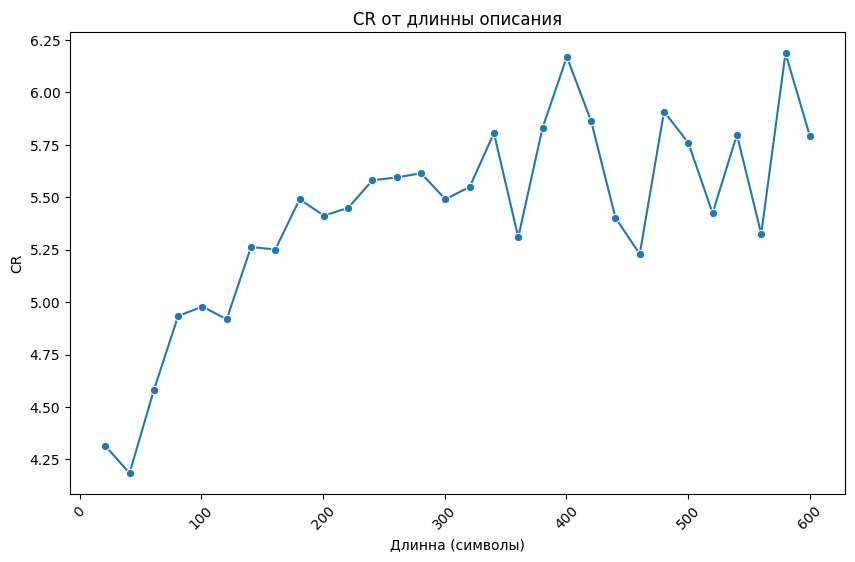

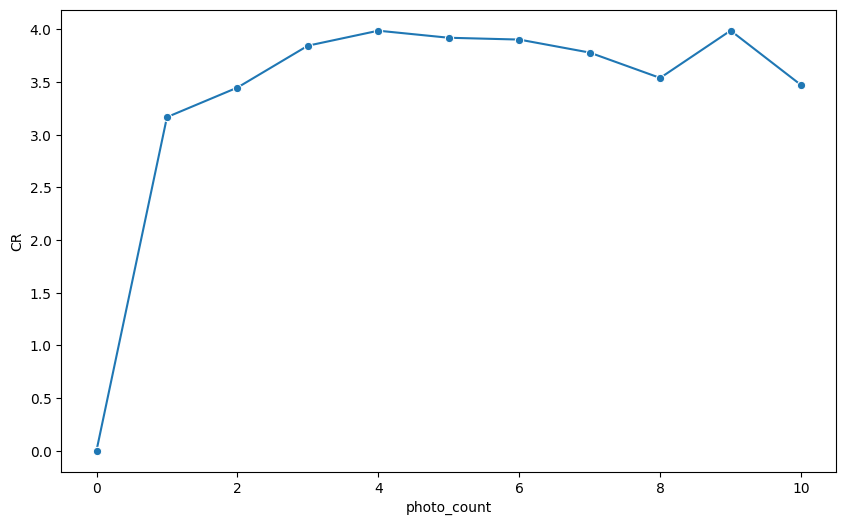

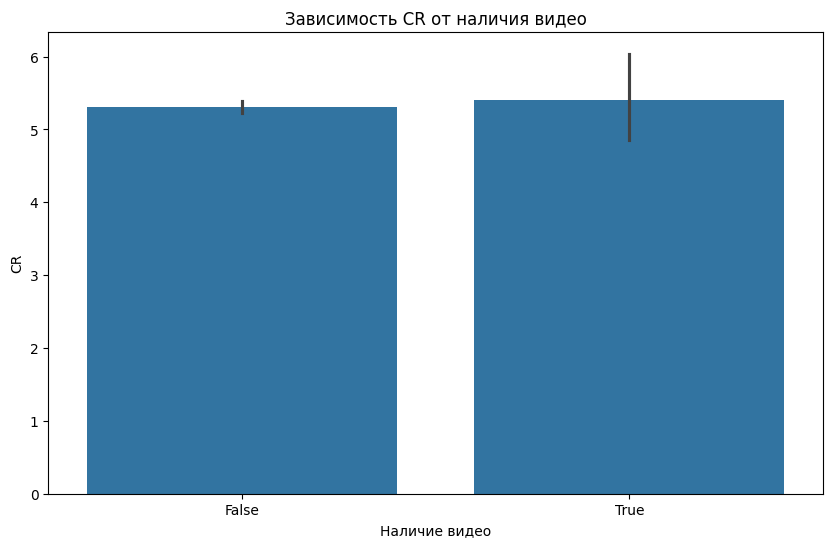

In [199]:
# Удаление NaN значений
df['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
df = df.dropna(subset=['category', 'age', 'description_length', 'CTR', 'CR', 'has_video'])
df['CR'].replace([np.inf, -np.inf], 0, inplace=True)
df['description_length'] = df['description_length'].clip(upper=600)
group_df = pd.DataFrame()

def plot_line(x, y, title, xlabel, ylabel, df=df, bins=20):

    # Создание интервалов для оси X
    df['x_bins'] = list(map(lambda x: x.right, pd.cut(df[x], bins=bins)))  # Разбиваем на интервалы
    # Вычисление среднего значения Y для каждого интервала
    median_data = df.groupby('x_bins')[y].mean().reset_index()  # Группировка и расчет среднего
    median_data = median_data.dropna()

    group_df['x_bins'] = median_data['x_bins']
    group_df['CR'] = median_data['CR']
    # Проверка на наличие данных в median_data
    if median_data.empty:
        print("Нет данных для построения графика.")
        return

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=median_data, x='x_bins', y=y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
    plt.show()
plot_line('description_length', 'CR', 'CR от длинны описания', 'Длинна (символы)', 'CR', df, bins=30)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df.groupby('photo_count')['CR'].median().reset_index(), x='photo_count', y='CR', marker='o')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='has_video', y='CR')
plt.title('Зависимость CR от наличия видео')
plt.xlabel('Наличие видео')
plt.ylabel('CR')
plt.show()

In [198]:
import statsmodels.api as sm


df2 = data
df2['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
df2['CR'].replace([np.inf, -np.inf], 0, inplace=True)
df2 = df2.dropna(subset=['category', 'age', 'description_length', 'CTR', 'CR', 'has_video'])

X = df2[['description_length', 'photo_count', 'has_video']].astype(int) # Независимые переменные
Y = df2['CR'] # Зависимая переменная

# Добавляем константу к независимым переменным
X = sm.add_constant(X)

# Создаем модель OLS
model = sm.OLS(Y, X)

# Подгоняем модель
results = model.fit()

# Выводим результаты
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     CR   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     20.66
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           2.25e-13
Time:                        03:17:02   Log-Likelihood:            -1.4228e+05
No. Observations:               40682   AIC:                         2.846e+05
Df Residuals:                   40678   BIC:                         2.846e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.8405      0

D:\Программы\Temp\Temp\ipykernel_18456\828524488.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
D:\Программы\Temp\Temp\ipykernel_18456\828524488.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh